In [52]:
%matplotlib inline
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append("../")

import aif360.algorithms.preprocessing
from aif360.datasets import BinaryLabelDataset, StructuredDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing


# for definition of original models
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report


import tensorflow as tf
from IPython.display import Markdown, display
import warnings

In [2]:
from collections import OrderedDict
from aif360.metrics import ClassificationMetric

def compute_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    metrics["Mean Difference"] = classified_metric_pred.mean_difference()
    
    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

 =========================== load and clean data ===========================

In [3]:
df = pd.read_csv('CMI_400.csv')
df_test = pd.read_csv('CMI_400_val.csv')

In [4]:
df_total_na = df.isna().sum().sum()                              
df_test_total_na = df_test.isna().sum().sum()                    

# Fill NA values with mean for numeric columns
for column in df.columns:
    if df[column].dtype in ['int64', 'float64']:
        df.fillna({column:df[column].mean()}, inplace=True)      
        
# Fill NA values with mean for numeric columns
for column in df_test.columns:
    if df_test[column].dtype in ['int64', 'float64']:
        df_test.fillna({column: df[column].mean()}, inplace=True)  
        
# Remove ID column
df = df.drop(['ID', 'TIV'], axis=1)
df_test = df_test.drop(['ID', 'TIV'], axis=1)

 =========================== create binary datasets ===========================

In [5]:
# Binarize Training data
label_name = ['target']
protected_attribute_names = ['Sex']
    
dataset_Binary = BinaryLabelDataset(
    df=df,
    label_names=label_name,
    protected_attribute_names=protected_attribute_names,
    favorable_label=0,
    unfavorable_label=1)
unique_labels = dataset_Binary.labels.ravel() 

if len(np.unique(unique_labels)) != 2:
    raise ValueError("Dataset does not contain binary labels")
    
for attr in protected_attribute_names:
    unique_attrs = dataset_Binary.protected_attributes[:, dataset_Binary.protected_attribute_names.index(attr)]
    if len(np.unique(unique_attrs)) != 2:
        raise ValueError(f"Protected attribute '{attr}' is not binary")

In [6]:
# Binarize Test data
dataset_orig_test = BinaryLabelDataset(
    df=df_test,
    label_names=label_name,
    protected_attribute_names=protected_attribute_names,
    favorable_label=0,
    unfavorable_label=1)
unique_labels = dataset_orig_test.labels.ravel()  

if len(np.unique(unique_labels)) != 2:
    raise ValueError("Dataset_val does not contain binary labels")
      
for attr in protected_attribute_names:
    unique_attrs = dataset_orig_test.protected_attributes[:, dataset_orig_test.protected_attribute_names.index(attr)]
    if len(np.unique(unique_attrs)) != 2:
        raise ValueError(f"Protected attribute '{attr}' is not binary")

In [7]:
# # print out some labels, names, etc.
# display(Markdown("#### Training Dataset shape"))
# print(dataset_Binary.features.shape)
# display(Markdown("#### Favorable and unfavorable labels"))
# print(dataset_Binary.favorable_label, dataset_Binary.unfavorable_label)
# display(Markdown("#### Protected attribute names"))
# print(dataset_Binary.protected_attribute_names)
# display(Markdown("#### Privileged and unprivileged protected attribute values"))
# print(dataset_Binary.privileged_protected_attributes, 
#       dataset_Binary.unprivileged_protected_attributes)
# display(Markdown("#### Dataset feature names"))
# print(dataset_Binary.feature_names)

In [8]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_valid = dataset_Binary.split([0.8])

privileged_groups = [{'Sex': 0}]
unprivileged_groups = [{'Sex': 1}]
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

display(Markdown("#### Original training dataset"))
print("mean difference = %f" % metric_orig_train.mean_difference())
print("disparate impact = %f" % metric_orig_train.disparate_impact())


#### Original training dataset

mean difference = 0.420719
disparate impact = 3.990517


In [9]:
smote = SMOTE(random_state=2)
X_train = dataset_orig_train.features
y_train = dataset_orig_train.labels.ravel()
X_train_sampled,y_train_sampled = smote.fit_resample(X_train, y_train)

scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(X_train_sampled)
y_train = y_train_sampled
X_test_scaled = scale_orig.transform(dataset_orig_test.features)

=========================== For Performing Adversarial Debiasing ===========================

In [10]:
# warnings.filterwarnings("ignore")
# tf.compat.v1.disable_eager_execution()  # Ensure TF2 compatibility
# sess = tf.compat.v1.Session()

# plain_model = aif360.algorithms.inprocessing.AdversarialDebiasing(
#     privileged_groups=privileged_groups,
#     unprivileged_groups=unprivileged_groups,
#     scope_name='original_model',
#     debias=False,
#     sess=sess,
#     # num_epochs=50,
#     # batch_size=128,
#     # classifier_num_hidden_units=128
# )

# plain_model.fit(dataset_orig_train)
# dataset_nodebiasing_train = plain_model.predict(dataset_orig_train)
# # dataset_nodebiasing_valid = plain_model.predict(dataset_orig_valid)
# dataset_nodebiasing_test = plain_model.predict(dataset_orig_test)

In [ ]:
# # Predictions at the optimal classification threshold before Debiasing
# # Find the optimal classification threshold from the validation set

# num_thresh = 100
# ba_arr = np.zeros(num_thresh)
# class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
# for idx, class_thresh in enumerate(class_thresh_arr):
    
#     fav_inds = dataset_nodebiasing_test.scores > class_thresh
#     dataset_nodebiasing_test.labels[fav_inds] = dataset_nodebiasing_test.favorable_label
#     dataset_nodebiasing_test.labels[~fav_inds] = dataset_nodebiasing_test.unfavorable_label
    
#     classified_metric_test = ClassificationMetric(dataset_orig_test,
#                                              dataset_nodebiasing_test, 
#                                              unprivileged_groups=unprivileged_groups,
#                                              privileged_groups=privileged_groups)
    
#     ba_arr[idx] = 0.5*(classified_metric_test.true_positive_rate()\
#                        +classified_metric_test.true_negative_rate())

# best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
# best_class_thresh = class_thresh_arr[best_ind]

# display(Markdown("#### Predictions from testing data before Adversarial Debiasing"))

# bal_acc_arr_orig = []
# disp_imp_arr_orig = []
# avg_odds_diff_arr_orig = []
# mean_diff_arr_orig = []

# print("Classification threshold used = %.4f" % best_class_thresh)
# for thresh in tqdm(class_thresh_arr):
    
#     if thresh == best_class_thresh:
#         disp = True
#     else:
#         disp = False
    
#     fav_inds = dataset_nodebiasing_test.scores > thresh
#     dataset_nodebiasing_test.labels[fav_inds] = dataset_nodebiasing_test.favorable_label
#     dataset_nodebiasing_test.labels[~fav_inds] = dataset_nodebiasing_test.unfavorable_label
    
#     metric_test_bef = compute_metrics(dataset_orig_test, dataset_nodebiasing_test, 
#                                       unprivileged_groups, privileged_groups,
#                                       disp = disp)

#     bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
#     avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
#     disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])
#     mean_diff_arr_orig.append(metric_test_bef["Mean Difference"])

In [12]:
# warnings.filterwarnings("ignore")
# # Learn parameters with debias set to True
# debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
#                           unprivileged_groups = unprivileged_groups,
#                           scope_name='debiased_classifier',
#                           debias=True,
#                           sess=sess)
# debiased_model.fit(dataset_orig_train)
# dataset_debiasing_train = debiased_model.predict(dataset_orig_train)
# # dataset_debiasing_valid = debiased_model.predict(dataset_orig_valid)
# dataset_debiasing_test = debiased_model.predict(dataset_orig_test)

In [ ]:
# # Predictions at the optimal classification threshold after Debiasing
# # Find the optimal classification threshold from the validation set

# num_thresh = 100
# ba_arr = np.zeros(num_thresh)
# class_thresh_arr_debiased = np.linspace(0.01, 0.99, num_thresh)
# for idx, class_thresh in enumerate(class_thresh_arr_debiased):
    
#     fav_inds = dataset_debiasing_test.scores > class_thresh
#     dataset_debiasing_test.labels[fav_inds] = dataset_debiasing_test.favorable_label
#     dataset_debiasing_test.labels[~fav_inds] = dataset_debiasing_test.unfavorable_label
    
#     classified_metric_test = ClassificationMetric(dataset_orig_test,
#                                              dataset_debiasing_test, 
#                                              unprivileged_groups=unprivileged_groups,
#                                              privileged_groups=privileged_groups)
    
#     ba_arr[idx] = 0.5*(classified_metric_test.true_positive_rate()\
#                        +classified_metric_test.true_negative_rate())

# best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
# best_class_thresh_debiased = class_thresh_arr_debiased[best_ind]

# display(Markdown("#### Predictions from testing data after Adversarial Debiasing"))

# bal_acc_arr_debiased = []
# disp_imp_arr_debiased = []
# avg_odds_diff_arr_debiased = []
# mean_diff_arr_debiased = []

# print("Classification threshold used = %.4f" % best_class_thresh_debiased)
# for thresh in tqdm(class_thresh_arr_debiased):
    
#     if thresh == best_class_thresh_debiased:
#         disp = True
#     else:
#         disp = False
    
#     fav_inds = dataset_debiasing_test.scores > thresh
#     dataset_debiasing_test.labels[fav_inds] = dataset_debiasing_test.favorable_label
#     dataset_debiasing_test.labels[~fav_inds] = dataset_debiasing_test.unfavorable_label
    
#     metric_test_bef = compute_metrics(dataset_orig_test, dataset_debiasing_test, 
#                                       unprivileged_groups, privileged_groups,
#                                       disp = disp)

#     bal_acc_arr_debiased.append(metric_test_bef["Balanced accuracy"])
#     avg_odds_diff_arr_debiased.append(metric_test_bef["Average odds difference"])
#     disp_imp_arr_debiased.append(metric_test_bef["Disparate impact"])
#     mean_diff_arr_debiased.append(metric_test_bef["Mean Difference"])

=========================== For Performing Prejudice Remover ===========================

In [14]:
# warnings.filterwarnings("ignore")
# # Learn parameters with debias set to True
# debiased_model_PR = aif360.algorithms.inprocessing.PrejudiceRemover()
# debiased_model_PR.fit(dataset_orig_train)

# dataset_debiasing_PR_train = debiased_model_PR.predict(dataset_orig_train)
# dataset_debiasing_PR_test = debiased_model_PR.predict(dataset_orig_test)

In [ ]:
# # Predictions at the optimal classification threshold after Prejudice Remover
# # Find the optimal classification threshold from the validation set
# num_thresh = 100
# ba_arr = np.zeros(num_thresh)
# class_thresh_arr_PR = np.linspace(0.01, 0.99, num_thresh)
# for idx, class_thresh in enumerate(class_thresh_arr_PR):
    
#     fav_inds = dataset_debiasing_PR_test.scores > class_thresh
#     dataset_debiasing_PR_test.labels[fav_inds] = dataset_debiasing_PR_test.favorable_label
#     dataset_debiasing_PR_test.labels[~fav_inds] = dataset_debiasing_PR_test.unfavorable_label
    
#     classified_metric_test_PR = ClassificationMetric(dataset_orig_test,
#                                              dataset_debiasing_PR_test, 
#                                              unprivileged_groups=unprivileged_groups,
#                                              privileged_groups=privileged_groups)
    
#     ba_arr[idx] = 0.5*(classified_metric_test_PR.true_positive_rate()\
#                        +classified_metric_test_PR.true_negative_rate())

# best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
# best_class_thresh_PR = class_thresh_arr_PR[best_ind]

# display(Markdown("#### Predictions of testing data after Prejudice Remover"))

# bal_acc_arr_PR = []
# disp_imp_arr_PR = []
# avg_odds_diff_arr_PR = []
# mean_diff_arr_PR = []

# print("Classification threshold used = %.4f" % best_class_thresh_PR)
# for thresh in tqdm(class_thresh_arr_PR):
    
#     if thresh == best_class_thresh_PR:
#         disp = True
#     else:
#         disp = False
    
#     fav_inds = dataset_debiasing_PR_test.scores > thresh
#     dataset_debiasing_PR_test.labels[fav_inds] = dataset_debiasing_PR_test.favorable_label
#     dataset_debiasing_PR_test.labels[~fav_inds] = dataset_debiasing_PR_test.unfavorable_label
    
#     metric_test_bef = compute_metrics(dataset_orig_test, dataset_debiasing_PR_test, 
#                                       unprivileged_groups, privileged_groups,
#                                       disp = disp)

#     bal_acc_arr_PR.append(metric_test_bef["Balanced accuracy"])
#     avg_odds_diff_arr_PR.append(metric_test_bef["Average odds difference"])
#     disp_imp_arr_PR.append(metric_test_bef["Disparate impact"])
#     mean_diff_arr_PR.append(metric_test_bef["Mean Difference"])

=========================== For pre- and post-processing algorithms: 
                            Train and evaluate original model ===========================

In [16]:
# # SVM definition

# # for grid search
# model = svm.SVC()
# parameters = {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear', 'poly'], 'gamma': [0.001, 0.1, 0.5]}
# grid_clf = GridSearchCV(estimator=model, param_grid=parameters)
# model_grid = grid_clf.fit(X_train_scaled,y_train_resampled)
# print(pd.DataFrame.from_dict(model_grid.cv_results_).loc[:,['params', 'mean_test_score']])
# print(model_grid.best_params_)
# grid_search = GridSearchCV(estimator=model_grid, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1)
# grid_search.fit(X_train, y_train)

# model = SVC(C=1, gamma=0.001, kernel='linear',  random_state=42, probability=True) 
# model.fit(X_train, y_train)

In [17]:
# # # XGBoost

# # # for grid search
# # model_grid = xgb.XGBClassifier()
# # param_grid = {
# #     'n_estimators': [100, 200, 300],
# #     'learning_rate': [0.01, 0.1, 0.2],
# #     'max_depth': [3, 5, 7],
# #     'min_child_weight': [1, 3, 5],
# #     'subsample': [0.6, 0.8, 1.0],
# #     'colsample_bytree': [0.6, 0.8, 1.0]
# # }
# # params=grid_search.best_params_
# # print(grid_search.best_params_)

model = XGBClassifier(colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, 
                          n_estimators=200, subsample=0.8, reg_alpha=0.1, reg_lambda=1.0, random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [18]:
y_train_pred = model.predict(X_train)

pos_ind = np.where(model.classes_ == dataset_orig_train.favorable_label)[0][0]
dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

=========================== For pre- and post-processing algorithms: Obtain scores for original validation and test sets ===========================

In [19]:
# # validation set
# dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
# X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
# y_valid = dataset_orig_valid_pred.labels
# dataset_orig_valid_pred.scores = model.predict_proba(X_valid)[:,pos_ind]

# test set
dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = model.predict_proba(X_test)[:,pos_ind]

In [20]:
# # Predictions from the original validation set at the optimal classification threshold
# # Find the optimal classification threshold from the validation set
# num_thresh = 100
# ba_arr = np.zeros(num_thresh)
# class_thresh_arr = np.linspace(0.0, 0.99, num_thresh)
# for idx, class_thresh in enumerate(class_thresh_arr):
    
#     fav_inds = dataset_orig_valid_pred.scores > class_thresh
#     dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
#     dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
#     classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
#                                              dataset_orig_valid_pred, 
#                                              unprivileged_groups=unprivileged_groups,
#                                              privileged_groups=privileged_groups)
    
#     ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
#                        +classified_metric_orig_valid.true_negative_rate())

# best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
# best_class_thresh = class_thresh_arr[best_ind]

# display(Markdown("#### Predictions from original validation data"))

# bal_acc_arr_orig = []
# disp_imp_arr_orig = []
# avg_odds_diff_arr_orig = []
# mean_diff_arr_orig = []

# print("Classification threshold used = %.4f" % best_class_thresh)
# for thresh in tqdm(class_thresh_arr):
    
#     if thresh == best_class_thresh:
#         disp = True
#     else:
#         disp = False
    
#     fav_inds = dataset_orig_valid_pred.scores > thresh
#     dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
#     dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
#     metric_valid_bef = compute_metrics(dataset_orig_valid, dataset_orig_valid_pred, 
#                                       unprivileged_groups, privileged_groups,
#                                       disp = disp)

#     bal_acc_arr_orig.append(metric_valid_bef["Balanced accuracy"])
#     avg_odds_diff_arr_orig.append(metric_valid_bef["Average odds difference"])
#     disp_imp_arr_orig.append(metric_valid_bef["Disparate impact"])
#     mean_diff_arr_orig.append(metric_valid_bef["Mean Difference"])


In [21]:
# Predictions from the original test set at the optimal classification threshold
# Find the optimal classification threshold from the test set
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_test_pred.scores > class_thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    classified_metric_test = ClassificationMetric(dataset_orig_test,
                                             dataset_orig_test_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_test.true_positive_rate()\
                       +classified_metric_test.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

display(Markdown("#### Predictions from original testing data"))

bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []
mean_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])
    mean_diff_arr_orig.append(metric_test_bef["Mean Difference"])

#### Predictions from original testing data

Classification threshold used = 0.4159


  0%|          | 0/100 [00:00<?, ?it/s]/home/len_lin/anaconda3/envs/aif360/lib/python3.11/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
/home/len_lin/anaconda3/envs/aif360/lib/python3.11/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
100%|██████████| 100/100 [00:00<00:00, 2721.21it/s]

Balanced accuracy = 0.8825
Statistical parity difference = 0.2137
Disparate impact = 1.3788
Average odds difference = 0.2568
Equal opportunity difference = 0.0488
Theil index = 0.0526
Mean Difference = 0.2137


In [22]:
# # Display results of Disparate Impact for all thresholds of original data

# fig, ax1 = plt.subplots(figsize=(10,7))
# ax1.plot(class_thresh_arr, bal_acc_arr_orig)
# ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
# ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
# ax1.xaxis.set_tick_params(labelsize=14)
# ax1.yaxis.set_tick_params(labelsize=14)


# ax2 = ax1.twinx()
# ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
# ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
# ax2.axvline(best_class_thresh, color='k', linestyle=':')
# ax2.yaxis.set_tick_params(labelsize=14)
# ax2.grid(True)
# plt.show()

In [23]:
# # Display results or mean difference for all thresholds of original data

# fig, ax1 = plt.subplots(figsize=(10,7))
# ax1.plot(class_thresh_arr, bal_acc_arr_orig)
# ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
# ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
# ax1.xaxis.set_tick_params(labelsize=14)
# ax1.yaxis.set_tick_params(labelsize=14)


# ax2 = ax1.twinx()
# ax2.plot(class_thresh_arr, mean_diff_arr_orig, color='r')
# ax2.set_ylabel('mean difference.', color='r', fontsize=16, fontweight='bold')
# ax2.axvline(best_class_thresh, color='k', linestyle=':')
# ax2.yaxis.set_tick_params(labelsize=14)
# ax2.grid(True)
# plt.show()

=========================== For pre- and post-processing algorithms: interpretation original model ===========================

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import shap
shap.initjs() 
import lime
import lime.lime_tabular
import warnings

In [25]:
X_train_XAI = pd.DataFrame(X_train) 
X_train_XAI.columns=df.columns[1:82]

X_test_XAI = pd.DataFrame(X_test) 
X_test_XAI.columns=df.columns[1:82]

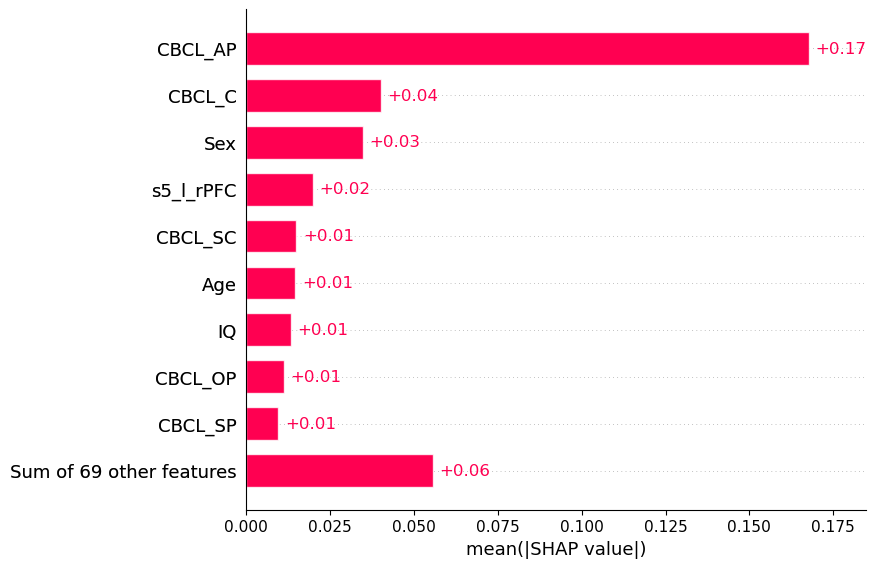

In [26]:
warnings.filterwarnings("ignore")
explainer_perm = shap.explainers.Permutation(model.predict_proba, X_test_XAI)
shap_values_perm = explainer_perm(X_test_XAI)
shap_values_perm = shap_values_perm[:,:,0]
shap.plots.bar(shap_values_perm)

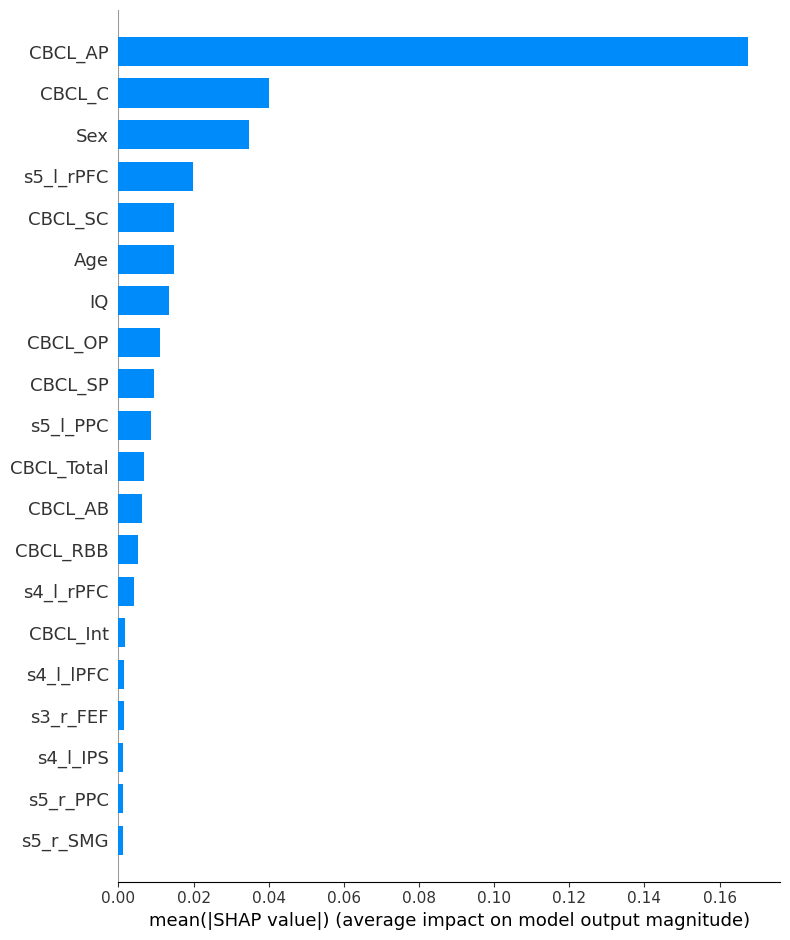

In [27]:
shap.summary_plot(shap_values_perm, X_test_XAI, plot_type="bar")

In [28]:
# Create a LIME explainer
class_names = [0, 1]
feature_names = list(X_train_XAI.columns)
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train_XAI.values, feature_names=feature_names, 
                                                        class_names=class_names, discretize_continuous=True)

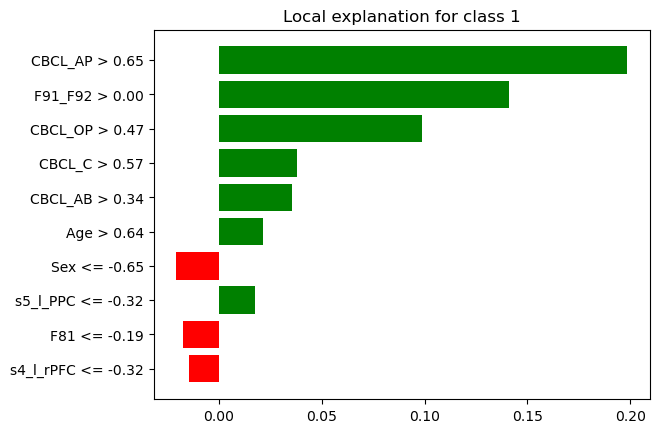

In [29]:
# # Get the LIME explanation for the chosen instance, e.g., 4
warnings.filterwarnings("ignore")
instance_idx = 4                            
exp = explainer_lime.explain_instance(data_row=X_test_XAI.iloc[instance_idx], predict_fn=model.predict_proba)
exp.as_pyplot_figure()
plt.show()
exp.show_in_notebook(show_table=True)

=========================== For Performing Calibrated Equal Odds Post-processing ===========================

In [30]:
# # Calibrated Equal Odds Post-processing

# # cost constraint of fnr will optimize generalized false negative rates, that of
# # fpr will optimize generalized false positive rates, and weighted will optimize
# # a weighted combination of both
# cost_constraint = "fnr" # "fnr", "fpr", "weighted"
# #random seed for calibrated equal odds prediction
# randseed = 12345679 

# cm_pred_test = ClassificationMetric(dataset_orig_test, dataset_orig_test_pred,
#                              unprivileged_groups=unprivileged_groups,
#                              privileged_groups=privileged_groups)
# display(Markdown("#### Original-Predicted testing dataset"))
# print("Difference in GFPR between unprivileged and privileged groups")
# print(cm_pred_test.difference(cm_pred_test.generalized_false_positive_rate))
# print("Difference in GFNR between unprivileged and privileged groups")
# print(cm_pred_test.difference(cm_pred_test.generalized_false_negative_rate))

In [31]:
# # Learn parameters to equalize odds and apply to create a new dataset
# cpp = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
#                                      unprivileged_groups = unprivileged_groups,
#                                      cost_constraint=cost_constraint,
#                                      seed=randseed)
# cpp = cpp.fit(dataset_orig_test, dataset_orig_test_pred)

# # dataset_transf_valid_pred = cpp.predict(dataset_orig_valid_pred)
# dataset_cpp_transf_test_pred = cpp.predict(dataset_orig_test_pred)

In [32]:
# cm_transf_test = ClassificationMetric(dataset_orig_test, dataset_cpp_transf_test_pred,
#                              unprivileged_groups=unprivileged_groups,
#                              privileged_groups=privileged_groups)
# display(Markdown("#### Transformed testing dataset"))
# print("Difference in GFPR between unprivileged and privileged groups")
# print(cm_transf_test.difference(cm_transf_test.generalized_false_positive_rate))
# print("Difference in GFNR between unprivileged and privileged groups")
# print(cm_transf_test.difference(cm_transf_test.generalized_false_negative_rate))

In [33]:
# # Testing: Check if the rates for test data has gone down
# assert np.abs(cm_transf_test.difference(cm_transf_test.generalized_false_negative_rate)) < np.abs(cm_pred_test.difference(cm_pred_test.generalized_false_negative_rate)) 

In [34]:
# all_thresh = np.linspace(0.01, 0.99, 25)
# display(Markdown("#### Classification thresholds used for validation and parameter selection"))

# bef_avg_odds_diff_test = []
# aft_avg_odds_diff_test = []
# bef_bal_acc_test = []
# aft_bal_acc_test = []

# for thresh in tqdm(all_thresh):
    
#     dataset_orig_test_pred_thresh = dataset_orig_test_pred.copy(deepcopy=True)
#     dataset_cpp_transf_test_pred_thresh = dataset_cpp_transf_test_pred.copy(deepcopy=True)
    
#     y_temp = np.zeros_like(dataset_orig_test_pred_thresh.labels)
#     y_temp[dataset_orig_test_pred_thresh.scores >= thresh] = dataset_orig_test_pred_thresh.favorable_label
#     y_temp[~(dataset_orig_test_pred_thresh.scores >= thresh)] = dataset_orig_test_pred_thresh.unfavorable_label
#     dataset_orig_test_pred_thresh.labels = y_temp
    

#     classified_metric_orig_test = ClassificationMetric(dataset_orig_test,
#                                                  dataset_orig_test_pred_thresh,
#                                                  unprivileged_groups=unprivileged_groups,
#                                                  privileged_groups=privileged_groups)
#     bef_avg_odds_diff_test.append(classified_metric_orig_test.equal_opportunity_difference())
#     bef_bal_acc_test.append(0.5*(classified_metric_orig_test.true_positive_rate()+
#                               classified_metric_orig_test.true_negative_rate()))

    
#     # Metrics for transf test data
#     classified_metric_transf_test = ClassificationMetric(dataset_orig_test,
#                                                  dataset_cpp_transf_test_pred_thresh,
#                                                  unprivileged_groups=unprivileged_groups,
#                                                  privileged_groups=privileged_groups)
#     aft_avg_odds_diff_test.append(classified_metric_transf_test.equal_opportunity_difference())
#     aft_bal_acc_test.append(0.5*(classified_metric_transf_test.true_positive_rate()+
#                                   classified_metric_transf_test.true_negative_rate()))

In [35]:
# bef_bal_acc_test = np.array(bef_bal_acc_test)
# bef_avg_odds_diff_test = np.array(bef_avg_odds_diff_test)

# aft_bal_acc_test = np.array(aft_bal_acc_test)
# aft_avg_odds_diff_test = np.array(aft_avg_odds_diff_test)

# fig, ax1 = plt.subplots(figsize=(13,7))
# ax1.plot(all_thresh, bef_bal_acc_test, color='b')
# ax1.plot(all_thresh, aft_bal_acc_test, color='b', linestyle='dashed')
# ax1.set_title('Original and Postprocessed testing data', fontsize=16, fontweight='bold')
# ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
# ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
# ax1.xaxis.set_tick_params(labelsize=14)
# ax1.yaxis.set_tick_params(labelsize=14)


# ax2 = ax1.twinx()
# ax2.plot(all_thresh, np.abs(bef_avg_odds_diff_test), color='r')
# ax2.plot(all_thresh, np.abs(aft_avg_odds_diff_test), color='r', linestyle='dashed')
# ax2.set_ylabel('abs(Equal opportunity diff)', color='r', fontsize=16, fontweight='bold')
# ax2.yaxis.set_tick_params(labelsize=14)
# ax2.grid(True)
# fig.legend(["Balanced Acc. - Orig.", "Balanced Acc. - Postproc.",
#             "Equal opp. diff. - Orig.", "Equal opp. diff. - Postproc."], 
#            fontsize=16)
# plt.show();

In [ ]:
# # Predictions at the optimal classification threshold after calibrated Equal Odds Post-processing
# # Find the optimal classification threshold from the validation set

# num_thresh = 100
# ba_arr = np.zeros(num_thresh)
# class_thresh_arr_transf_cpp = np.linspace(0.01, 0.99, num_thresh)
# for idx, class_thresh in enumerate(class_thresh_arr_transf_cpp):
    
#     fav_inds = dataset_cpp_transf_test_pred.scores > class_thresh
#     dataset_cpp_transf_test_pred.labels[fav_inds] = dataset_cpp_transf_test_pred.favorable_label
#     dataset_cpp_transf_test_pred.labels[~fav_inds] = dataset_cpp_transf_test_pred.unfavorable_label
    
#     classified_metric_test_transf_cpp = ClassificationMetric(dataset_orig_test,
#                                              dataset_cpp_transf_test_pred, 
#                                              unprivileged_groups=unprivileged_groups,
#                                              privileged_groups=privileged_groups)
    
#     ba_arr[idx] = 0.5*(classified_metric_test_transf_cpp.true_positive_rate()\
#                        +classified_metric_test_transf_cpp.true_negative_rate())

# best_ind_cpp = np.where(ba_arr == np.max(ba_arr))[0][0]
# best_class_thresh_cpp = class_thresh_arr_transf_cpp[best_ind]

# display(Markdown("#### Predictions from cEOP-transformed testing data"))
# bal_acc_arr_transf_cpp = []
# disp_imp_arr_transf_cpp = []
# avg_odds_diff_arr_transf_cpp = []
# mean_diff_arr_transf_cpp = []

# print("Classification threshold used = %.4f" % best_class_thresh_cpp)
# for thresh in tqdm(class_thresh_arr_transf_cpp):
    
#     if thresh == best_class_thresh_cpp:
#         disp = True
#     else:
#         disp = False
    
#     fav_inds = dataset_cpp_transf_test_pred.scores > thresh
#     dataset_cpp_transf_test_pred.labels[fav_inds] = dataset_cpp_transf_test_pred.favorable_label
#     dataset_cpp_transf_test_pred.labels[~fav_inds] = dataset_cpp_transf_test_pred.unfavorable_label
    
#     metric_test_aft_cpp = compute_metrics(dataset_orig_test, dataset_cpp_transf_test_pred, 
#                                       unprivileged_groups, privileged_groups,
#                                       disp = disp)

#     bal_acc_arr_transf_cpp.append(metric_test_aft_cpp["Balanced accuracy"])
#     avg_odds_diff_arr_transf_cpp.append(metric_test_aft_cpp["Average odds difference"])
#     disp_imp_arr_transf_cpp.append(metric_test_aft_cpp["Disparate impact"])
#     mean_diff_arr_transf_cpp.append(metric_test_aft_cpp["Mean Difference"])

=========================== For pre- and post-processing algorithms: transform data ===========================

In [37]:
# # preprocessing algorithms 

RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

# DIR = aif360.algorithms.preprocessing.DisparateImpactRemover(
#         repair_level=1,  # Repair level between 0 and 1
#         sensitive_attribute='Sex')

# dataset_transf_train = DIR.fit_transform(dataset_orig_train)  

In [38]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)

display(Markdown("#### Transformed training dataset "))
print("mean difference = %f" % metric_transf_train.mean_difference())
print("disparate impact = %f" % metric_transf_train.disparate_impact())

#### Transformed training dataset 

mean difference = -0.000000
disparate impact = 1.000000


=========================== For pre- and post-processing algorithms: Train classifier on transformed data ===========================

In [39]:
smote_transf = SMOTE(random_state=2)
X_train_transf = dataset_transf_train.features
y_train_transf = dataset_transf_train.labels.ravel()
X_train_transf_sampled,y_train_transf_sampled = smote_transf.fit_resample(X_train_transf, y_train_transf)

scale_transf = StandardScaler()
X_train_transf = scale_transf.fit_transform(X_train_transf_sampled)
y_train_transf = y_train_transf_sampled

In [40]:
# # transfer SVM model
# model_transf = SVC(C=1, gamma=0.001, kernel='linear',  random_state=42, probability=True) 
# model_transf.fit(X_train_transf, y_train_transf)

# pos_ind = np.where(model_transf.classes_ == dataset_transf_train.favorable_label)[0][0]
# y_train_transf_pred = model_transf.predict(X_train_transf)

In [41]:
# transfer XGBoost model
model_transf = XGBClassifier(colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=200, 
                          subsample=0.8, reg_alpha=0.1, reg_lambda=1.0, random_state=42)
model_transf.fit(X_train_transf, y_train_transf)

pos_ind = np.where(model_transf.classes_ == dataset_transf_train.favorable_label)[0][0]
y_train_transf_pred = model_transf.predict(X_train_transf)

=========================== For pre- and post-processing algorithms: Obtain scores for transformed test set ===========================

In [42]:
# dataset_transf_valid_pred = dataset_orig_valid.copy(deepcopy=True)
# X_valid = scale_transf.fit_transform(dataset_transf_valid_pred.features)
# y_valid = dataset_transf_valid_pred.labels
# dataset_transf_valid_pred.scores = model.predict_proba(X_valid)[:,pos_ind]

In [43]:
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test_transf = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test_transf = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = model_transf.predict_proba(X_test_transf)[:,pos_ind]

In [44]:
# Predictions from the transformed test set at the optimal classification threshold
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr_transf = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr_transf):
    
    fav_inds = dataset_transf_test_pred.scores > class_thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    classified_metric_test_transf = ClassificationMetric(dataset_orig_test,
                                             dataset_transf_test_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_test_transf.true_positive_rate()\
                       +classified_metric_test_transf.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr_transf[best_ind]

display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []
mean_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr_transf):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])
    mean_diff_arr_transf.append(metric_test_aft["Mean Difference"])

#### Predictions from transformed testing data

Classification threshold used = 0.7128


100%|██████████| 100/100 [00:00<00:00, 2670.07it/s]

Balanced accuracy = 0.8937
Statistical parity difference = -0.1709
Disparate impact = 0.7222
Average odds difference = -0.0959
Equal opportunity difference = 0.0244
Theil index = 0.0406
Mean Difference = -0.1709


In [45]:
# # Display Disparate Impact results for all thresholds on transferred data

# fig, ax1 = plt.subplots(figsize=(10,7))
# ax1.plot(class_thresh_arr_transf, bal_acc_arr_transf)
# ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
# ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
# ax1.xaxis.set_tick_params(labelsize=14)
# ax1.yaxis.set_tick_params(labelsize=14)


# ax2 = ax1.twinx()
# ax2.plot(class_thresh_arr_transf, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
# ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
# ax2.axvline(best_class_thresh, color='k', linestyle=':')
# ax2.yaxis.set_tick_params(labelsize=14)
# ax2.grid(True)
# plt.show()

In [46]:
# # Display Mean Difference results for all thresholds on transferred data

# fig, ax1 = plt.subplots(figsize=(10,7))
# ax1.plot(class_thresh_arr_transf, bal_acc_arr_transf)
# ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
# ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
# ax1.xaxis.set_tick_params(labelsize=14)
# ax1.yaxis.set_tick_params(labelsize=14)


# ax2 = ax1.twinx()
# ax2.plot(class_thresh_arr_transf, np.abs(1.0-np.array(mean_diff_arr_transf)), color='r')
# ax2.set_ylabel('mean difference', color='r', fontsize=16, fontweight='bold')
# ax2.axvline(best_class_thresh, color='k', linestyle=':')
# ax2.yaxis.set_tick_params(labelsize=14)
# ax2.grid(True)
# plt.show()

=========================== For pre- and post-processing algorithms: interpretation transfered model ===========================

In [47]:
X_train_transf = pd.DataFrame(X_train_transf) 
X_train_transf.columns=df.columns[1:82]

X_test_transf = pd.DataFrame(X_test_transf) 
X_test_transf.columns=df.columns[1:82]

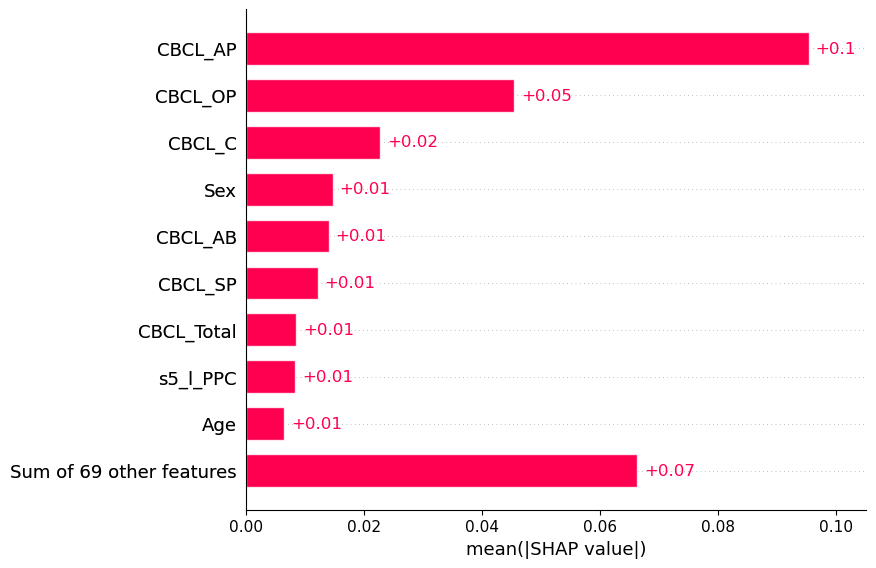

In [48]:
explainer_perm = shap.explainers.Permutation(model_transf.predict_proba, X_test_transf)
shap_values_perm = explainer_perm(X_test_transf)
shap_values_perm = shap_values_perm[:,:,0]
shap.plots.bar(shap_values_perm)

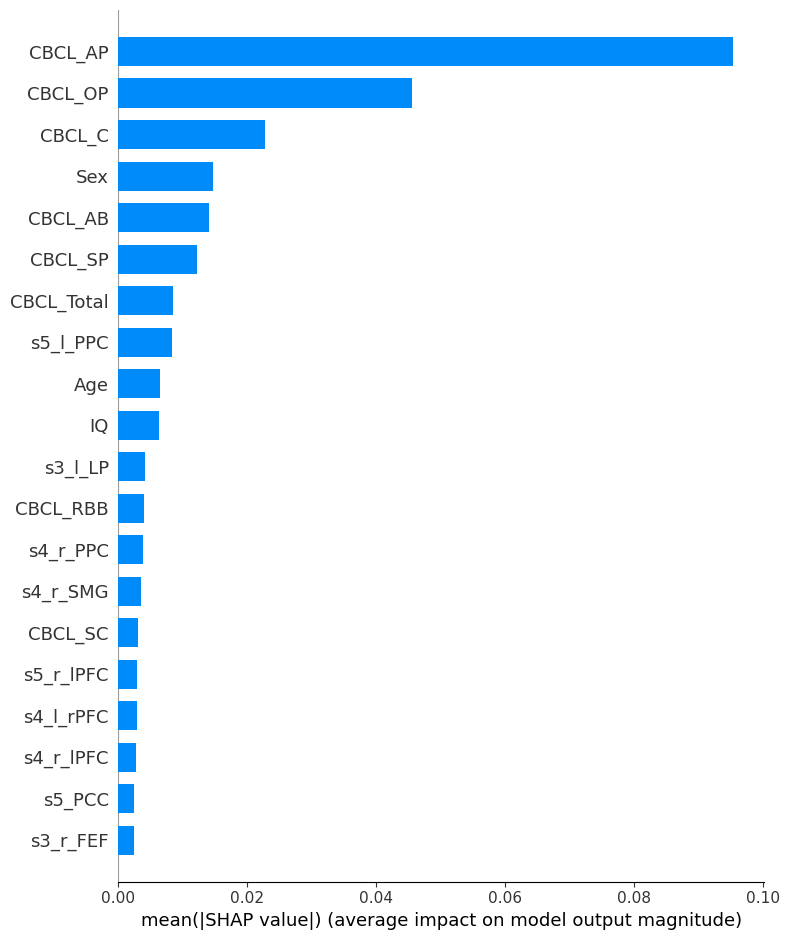

In [49]:
shap.summary_plot(shap_values_perm, X_test_transf, plot_type="bar")

In [50]:
# Create a LIME explainer
class_names = [0, 1]
feature_names = list(X_train_transf.columns)
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train_transf.values, feature_names=feature_names, 
                                                        class_names=class_names, discretize_continuous=True)

In [51]:
# Get the LIME explanation for the chosen instance
warnings.filterwarnings("ignore")
instance_idx = 4
exp = explainer_lime.explain_instance(data_row=X_test_transf.iloc[instance_idx], predict_fn=model_transf.predict_proba)
exp.as_pyplot_figure()
exp.show_in_notebook(show_table=True)